# Spike-Timing-Dependent Plasticity

STDP learning rule describes the change of synapses weight. According to STDP rule, synapses adjusts its connection strength based on the relative timing of pre-synaptic and post-synaptic spikes.

In [1]:
import matplotlib.pyplot as plt
import brainpy as bp
import numpy as np
import bpmodels
from bpmodels.neurons import get_LIF
from bpmodels.learning_rules import get_STDP1, get_STDP2

In [2]:
# set params
duration = 550.
dt = 0.02
bp.profile.set(jit=True, dt = dt, merge_steps = True, show_code = False)# set params
delta_t = [-20, -15, -10, -8, -6, -4, -3, 
           -2, -1, -0.6, -0.3, -0.2, -0.1, 
           0, 
           0.1, 0.2, 0.3, 0.6, 1, 2, 3, 
           4, 6, 8, 10, 15, 20] 
# delta_t: time difference between post and pre-synaptic spikes
pre_spike_t = range(50, 550, 50) #pre neuron spike time train
delta_t_num = len(delta_t)
spike_num = len(pre_spike_t)

Import synapses with STDP learning rule from bpmodels package. Build and simulate a network to show how STDP works. Note that using vector based model, we can simulate synapses with different input simultaneously.

In [3]:
# import model
STDP_syn = get_STDP1()

# build SynConn
stdp = bp.SynConn(model = STDP_syn, num = delta_t_num, 
                  monitors = ['w', 'A_s', 'A_t', 'g'], delay = 10.)
                  # 1 synapse corresponds to 1 delta_t (for parallel computing)
stdp.ST["A_s"] = 0.
stdp.ST["A_t"] = 0.
stdp.ST['w'] = 10.
stdp.runner.set_schedule(['input', 'update', 'output', 'monitor'])
stdp.pre = bp.types.NeuState(['spike'])(delta_t_num)
stdp.post = bp.types.NeuState(['V', 'input', 'spike'])(delta_t_num)

# build pre-syn-post connection
pre2syn_list = []
post2syn_list = []
for i in range(delta_t_num):
    pre2syn_list.append([i, i])
    post2syn_list.append([i, i])
stdp.pre2syn = stdp.requires['pre2syn'].make_copy(pre2syn_list)
stdp.post2syn = stdp.requires['post2syn'].make_copy(post2syn_list)

# build network
net = bp.Network(stdp)

# create input matrix
## combine input of different delta_t (for parallel computing)
current_pre_mat = []
current_post_mat = []
for i in range(delta_t_num):
    I_ext_pre = []
    I_ext_post = []
    for j in range(spike_num):
        I_ext_pre.append(pre_spike_t[j])
        I_ext_post.append(pre_spike_t[j] + delta_t[i])

    current_pre = bp.inputs.spike_current(I_ext_pre, 
                                          bp.profile._dt, 1., duration = duration)
    current_post = bp.inputs.spike_current(I_ext_post, 
                                           bp.profile._dt, 1., duration = duration)                                    
    if i==0:
        current_pre_mat = current_pre
        current_post_mat = current_post
    else:
        current_pre_mat = np.vstack((current_pre_mat, current_pre))
        current_post_mat = np.vstack((current_post_mat, current_post))

# simulate                              
net.run(duration = duration, 
        inputs = (
        [stdp, 'pre.spike', current_pre_mat.T, "="], 
        [stdp, 'post.spike', current_post_mat.T, "="]
        ), 
        report = False)

Process data and paint delta_w-delta_t plot. Show that the change of synapse weight w depends on the relative time of pre-synaptic and post-synaptic spikes.

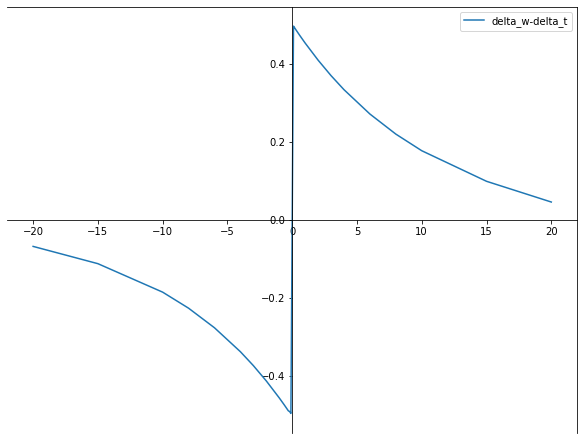

In [4]:
# process data
delta_w_list = []
for i in range(delta_t_num):
    output = stdp.mon.w[:, i]
    delta_w = 0
    for j in range(spike_num):
        base = int(I_ext_pre[j]//dt)
        bias = int(I_ext_post[j]//dt)
        if base > bias:
            deltaw = output[base + 10] - output[bias - 10]
        else:
            deltaw = output[bias + 10] - output[base - 10]
        delta_w += deltaw
    delta_w /= spike_num
    delta_w_list.append(delta_w)
        
# paint
ts = net.ts
fig, gs = bp.visualize.get_figure(1, 1, 6, 8)
ax = fig.add_subplot(gs[0, 0])
fig.add_subplot(ax)
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0.))
plt.plot(delta_t, delta_w_list, label = 'delta_w-delta_t')
plt.legend()
plt.show()